In [1]:
import mne
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
data = pd.read_csv("data/eval/00000647_s002_t000.csv", skiprows=1)
data.columns = [item.strip("# ") for item in data.columns]

In [3]:
data

,EEG FP1-REF,EEG FP2-REF,EEG F3-REF,EEG F4-REF,EEG C3-REF,EEG C4-REF,EEG P3-REF,EEG P4-REF,EEG O1-REF,EEG O2-REF,...,EEG 27-REF,EEG 28-REF,EEG 29-REF,EEG 30-REF,EEG T1-REF,EEG T2-REF,PHOTIC-REF,IBI,BURSTS,SUPPR
0,-26.852,-6.253,18.161,9.159,-10.067,5.344,-10.983,-0.149,-7.931,-7.168,...,54.782,-5.337,15.415,15.720,5.191,7.480,0.0,0.0,0.0,0.0
1,14.042,-23.037,20.908,6.870,-4.879,5.649,-5.642,1.529,-4.269,-4.421,...,106.205,3.666,19.840,27.164,4.886,6.260,0.0,0.0,0.0,0.0
2,-10.678,-13.424,12.210,3.055,-4.727,5.954,-3.353,1.682,-4.269,-5.490,...,66.227,0.309,23.349,36.319,3.360,7.785,0.0,0.0,0.0,0.0
3,-4.116,15.568,-5.490,2.292,-8.236,4.123,-5.032,0.461,-6.405,-7.931,...,8.396,-20.901,8.243,28.690,0.309,0.766,0.0,0.0,0.0,0.0
4,-15.866,1.377,4.123,5.191,0.004,1.987,-0.454,1.072,-6.253,-7.473,...,46.085,-10.220,13.279,21.213,3.971,1.529,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300495,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.0,0.0,0.0,0.0
300496,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.0,0.0,0.0,0.0
300497,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.0,0.0,0.0,0.0
300498,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.0,0.0,0.0,0.0


In [4]:
data["IBI"].value_counts()

IBI
0.0            101750
61900000.0      31500
22200000.0      31250
3700000.0       28750
8800000.0       27500
11600000.0      26000
37300000.0      21500
38800000.0      11250
3900000.0       10250
107100000.0      8750
10800000.0       2000
Name: count, dtype: int64

In [5]:
ch_names = [item for item in data.columns]
ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG ROC-REF',
 'EEG LOC-REF',
 'EEG EKG1-REF',
 'EMG-REF',
 'EEG 26-REF',
 'EEG 27-REF',
 'EEG 28-REF',
 'EEG 29-REF',
 'EEG 30-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR']

In [7]:
sfreq = 250

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg", verbose=True)
raw = mne.io.RawArray(data.values.T, info)


Creating RawArray with float64 data, n_channels=36, n_times=300500
    Range : 0 ... 300499 =      0.000 ...  1201.996 secs
Ready.


In [10]:
print(raw)
print(raw.info)

<RawArray | 36 x 300500 (1202.0 s), ~82.6 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 36
 projs: []
 sfreq: 250.0 Hz
>


In [13]:
raw.plot()

Channels marked as bad:
none


In [7]:
# raw.save("raw_test.fif", overwrite=True)

In [8]:
# raw = mne.io.read_raw_fif("raw_test.fif")
# raw

Effective window size : 1.024 (s)


/tmp/ipykernel_13474/1907353501.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks="all").plot(picks="all")
/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


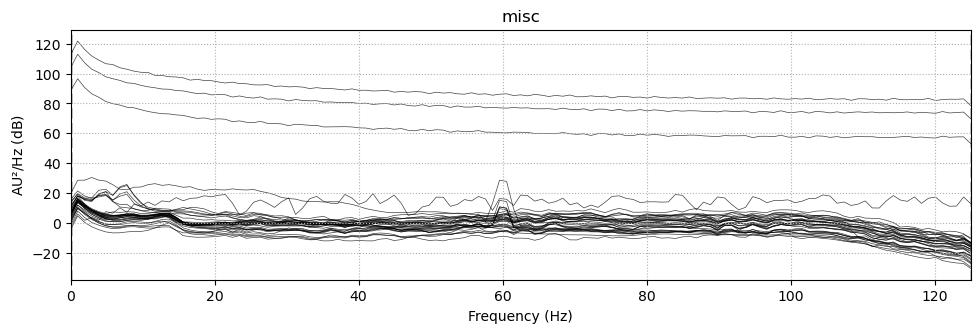

In [24]:
raw.compute_psd(picks="all").plot(picks="all")

In [12]:
ica = mne.preprocessing.ICA(n_components=10, random_state=97)
ica.fit(raw, picks="eeg")

Fitting ICA to data using 36 channels (please be patient, this may take a while)


/tmp/ipykernel_14320/921328437.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, picks="eeg")


Selecting by number: 10 components
Fitting ICA took 1.5s.


/tmp/ipykernel_14320/921328437.py:2: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (14) and smallest (1.2e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
  ica.fit(raw, picks="eeg")


Method,fastica
Fit,14 iterations on raw data (300500 samples)
ICA components,10
Available PCA components,36
Channel types,eeg
ICA components marked for exclusion,—


    Using multitaper spectrum estimation with 7 DPSS windows


RuntimeError: No digitization points found.

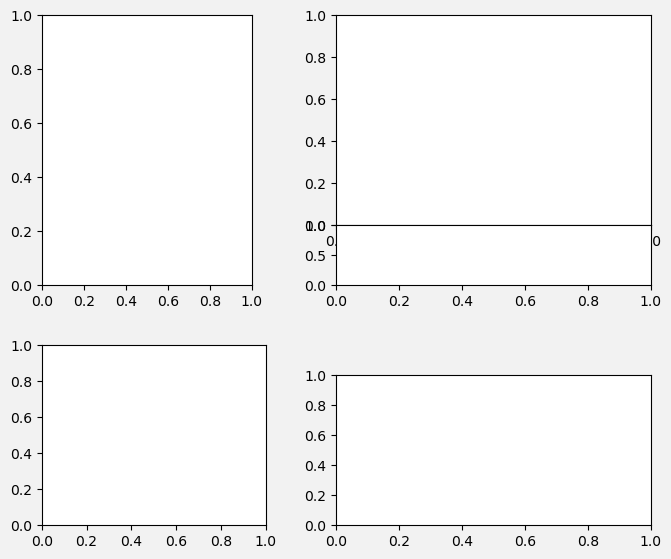

In [16]:
ica.plot_properties(raw, picks=[1,2])